In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
nltk.download("stopwords") #stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
folder_path = "/content/drive/MyDrive/mufg"

csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

spam_nonspam_counts = {}
datasets = {}

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    try:
        df = pd.read_csv(file_path)
        df.columns = [c.strip().lower() for c in df.columns]  # clean column names
        datasets[file] = df

        # Detect label column
        label_col = next((c for c in df.columns if 'label' in c), None)
        if label_col:
            spam_count = df[df[label_col] == 1].shape[0]
            non_spam_count = df[df[label_col] == 0].shape[0]
        else:
            spam_count = df.shape[0]  # all considered spam
            non_spam_count = 0

        spam_nonspam_counts[file] = {'spam_count': spam_count, 'non_spam_count': non_spam_count}
        print(f"{file}: {spam_count} spam, {non_spam_count} non-spam")

    except Exception as e:
        print(f"Error loading {file}: {e}")

Nigerian_Fraud.csv: 3332 spam, 0 non-spam
Nazario.csv: 1565 spam, 0 non-spam
phishing_email.csv: 42891 spam, 39595 non-spam
Ling.csv: 458 spam, 2401 non-spam
Enron.csv: 13976 spam, 15791 non-spam
CEAS_08.csv: 21842 spam, 17312 non-spam
SpamAssasin.csv: 1718 spam, 4091 non-spam


In [ ]:
combined_data = []

for file, df in datasets.items():
    # Detect text column
    text_col = next((c for c in df.columns if 'text' in c or 'message' in c or 'content' in c or 'body' in c), None)

    if text_col:
        df_subset = df[[text_col]].copy()

        # Add label column
        label_col = next((c for c in df.columns if 'label' in c), None)
        if label_col:
            df_subset['label'] = df[label_col]
        else:
            df_subset['label'] = 1  # all spam if missing

        # Rename and add source
        df_subset.columns = ['text', 'label']
        df_subset['source'] = file

        combined_data.append(df_subset)
        print(f"Added {len(df_subset)} emails from {file}")
    else:
        print(f"Skipping {file}: No text column found")


Added 3332 emails from Nigerian_Fraud.csv
Added 1565 emails from Nazario.csv
Added 82486 emails from phishing_email.csv
Added 2859 emails from Ling.csv
Added 29767 emails from Enron.csv
Added 39154 emails from CEAS_08.csv
Added 5809 emails from SpamAssasin.csv


In [ ]:
if combined_data:
    combined_df = pd.concat(combined_data, ignore_index=True)
    print(f"\nCombined dataset created with {len(combined_df)} emails")
else:
    raise ValueError("No datasets with text content found!")



Combined dataset created with 164972 emails


In [ ]:
def preprocess_text(df):
    df = df.copy()
    df = df.dropna(subset=['text'])
    df['text'] = df['text'].astype(str).str.lower().str.strip()
    df = df[df['text'].str.len() > 0]
    return df

combined_df = preprocess_text(combined_df)
print(f"After preprocessing: {len(combined_df)} emails")
print("\nClass distribution:")
print(combined_df['label'].value_counts())

After preprocessing: 164966 emails

Class distribution:
label
1    85776
0    79190
Name: count, dtype: int64


In [ ]:
spam_df = combined_df[combined_df['label'] == 1]
non_spam_df = combined_df[combined_df['label'] == 0]

if len(non_spam_df) > 0:
    # Sample the smaller of len(spam_df) or len(non_spam_df)
    sample_size = min(len(spam_df), len(non_spam_df))
    non_spam_df = non_spam_df.sample(sample_size, random_state=42)
else:
    print("No non-spam emails found; using only spam emails for the dataset.")

df_balanced = pd.concat([spam_df, non_spam_df]).sample(frac=1, random_state=42)
print(f"\nTotal samples after balancing: {len(df_balanced)}")



Total samples after balancing: 164966


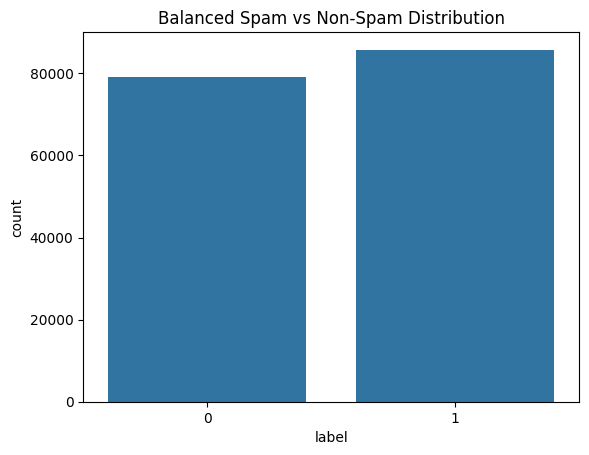

In [ ]:
sns.countplot(data=df_balanced, x='label')
plt.title("Balanced Spam vs Non-Spam Distribution")
plt.show()

In [ ]:
X = df_balanced['text']
Y = df_balanced['label']

In [ ]:
def create_svm_pipeline(use_undersampling=True, max_features=1000):
    """Create SVM pipeline with optional undersampling"""

    if use_undersampling:
        from imblearn.pipeline import Pipeline as ImbPipeline
        from imblearn.under_sampling import RandomUnderSampler
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.svm import SVC

        pipeline = ImbPipeline([
            ('tfidf', TfidfVectorizer(
                max_features=max_features,
                stop_words='english',
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.95,
                lowercase=True,
                strip_accents='unicode'
            )),
            ('undersampler', RandomUnderSampler(random_state=42)),
            ('svm', SVC(
                kernel='linear',
                C=1.0,
                probability=True,
                random_state=42
            ))
        ])
    else:
        from sklearn.pipeline import Pipeline
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.svm import SVC

        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=max_features,
                stop_words='english',
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.95,
                lowercase=True,
                strip_accents='unicode'
            )),
            ('svm', SVC(
                kernel='linear',
                C=1.0,
                probability=True,
                random_state=42
            ))
        ])

    return pipeline


In [ ]:
pipeline = create_svm_pipeline(use_undersampling=False, max_features=1000)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=1000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english',
                                 strip_accents='unicode')),
                ('svm',
                 SVC(kernel='linear', probability=True, random_state=42))])

In [ ]:
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

In [ ]:
print("Training accuracy:", accuracy_score(Y_train, train_pred))
print("Testing accuracy:", accuracy_score(Y_test, test_pred))

Training accuracy: 0.9647728306004304
Testing accuracy: 0.9640237618961023


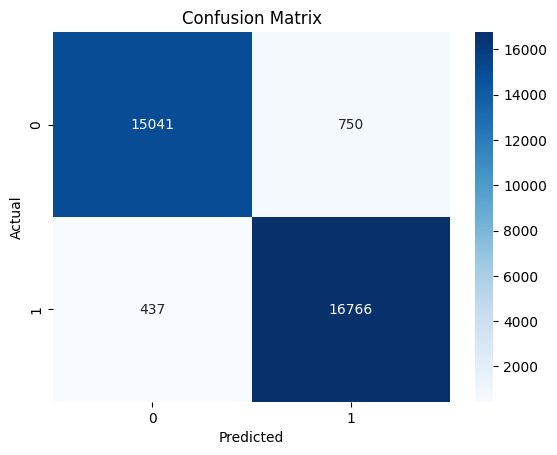

In [ ]:
cm = confusion_matrix(Y_test, test_pred)
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
report = classification_report(Y_test, test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     15791
           1       0.96      0.97      0.97     17203

    accuracy                           0.96     32994
   macro avg       0.96      0.96      0.96     32994
weighted avg       0.96      0.96      0.96     32994



In [ ]:
sample_emails = [
    "Congratulations!!! You have won $1,000,000 in our lottery! Click here to claim your prize immediately!",
    "Hey there Sneha, can you please send me the report by tomorrow? Thanks!",
    """Hello Students,
    You’ve been shortlisted for the 2025 Accenture Verified Training and Internship Program.
    This initiative provides guidance on resumes, interviews, and placements with industry-leading companies.

    To move forward, please complete the registration steps before the deadline.

    Dear Students,
    We are delighted to announce an exclusive collaboration with leading multinational companies,
    including Accenture, Wipro, IBM, Microsoft, Deloitte, EY, Cisco, Cognizant, Barclays, Infosys, Genpact, Oracle, TCS, PwC, J.P. Morgan, Amazon, Accenture, HCL Technologies, Tech Mahindra, and many more.

    Join us for a comprehensive 3-month Training, Internship, and Placement Program designed to equip you with essential industry skills and enhance your career prospects. Led by industry experts with over 10+ years of experience, this program provides a structured learning experience, hands-on exposure, and placement opportunities in top organizations.

    Program Overview
    Month 1: Practical Learning & Industry Training
        - Participate in interactive live sessions covering both fundamental and advanced industry topics led by professionals.
        - Engage in live discussions, hands-on exercises, and personalized doubt-clearing sessions to strengthen conceptual understanding.
        - Classes conducted Monday to Friday via Zoom or Google Meet, ensuring accessibility and flexibility.

    Month 2: Internship & Project-Based Learning
        - Gain practical exposure by working on real-world projects under the mentorship of industry experts.
        - Complete a minor individual project (1 week) followed by a major group project (3 weeks), allowing for skill application in a collaborative environment.

    Month 3: Placement Assistance & Job Readiness
        - Receive comprehensive placement support, including mock interviews, group discussions, resume-building workshops, and communication skill enhancement sessions.
        - Benefit from personalized career guidance to improve your job search strategy and increase your chances of securing a placement.

    Certificates Awarded
        - Internship Completion Certificate (Accenture Certified)
        - Course Completion Certificate (ISO Certified)
        - Letter of Recommendation (LOR) from leading multinational companies
        - Certificate of Excellence for outstanding performers

    Important Note: Training fees are applicable.
    This program is an Industrial Training and Professional Upskilling initiative designed to enhance career prospects through hands-on projects with multinational corporations (MNCs).
    A training fee is required to access the full benefits, including expert-led sessions, practical learning experiences, and placement support."""
]

print("Testing with sample emails:")
print("=" * 80)

for i, email in enumerate(sample_emails, 1):
    pred = pipeline.predict([email])[0]
    proba = pipeline.predict_proba([email])[0]

    print(f"\nEmail {i}:")
    print(f"Text: {email}")
    print(f"Prediction: {'SPAM' if pred == 1 else 'NON-SPAM'}")
    print(f"Probability of SPAM: {proba[1]:.4f}")   # index 1 = spam prob
    print(f"Probability of NON-SPAM: {proba[0]:.4f}")
    print("-" * 80)

Testing with sample emails:

Email 1:
Text: Congratulations!!! You have won $1,000,000 in our lottery! Click here to claim your prize immediately!
Prediction: SPAM
Probability of SPAM: 1.0000
Probability of NON-SPAM: 0.0000
--------------------------------------------------------------------------------

Email 2:
Text: Hey there Sneha, can you please send me the report by tomorrow? Thanks!
Prediction: NON-SPAM
Probability of SPAM: 0.0454
Probability of NON-SPAM: 0.9546
--------------------------------------------------------------------------------

Email 3:
Text: Hello Students,
    You’ve been shortlisted for the 2025 Accenture Verified Training and Internship Program.
    This initiative provides guidance on resumes, interviews, and placements with industry-leading companies.

    To move forward, please complete the registration steps before the deadline.

    Dear Students,
    We are delighted to announce an exclusive collaboration with leading multinational companies,
    includ

In [ ]:
import joblib

# Save the trained pipeline (includes TF-IDF + SVM)
joblib.dump(pipeline, "email_pipeline.pkl")

print("Model saved as 'email_pipeline.pkl'")

Model saved as 'email_pipeline.pkl'


In [ ]:
from google.colab import drive
import joblib

drive.mount('/content/drive')
joblib.dump(pipeline, "/content/drive/MyDrive/mufg/email_pipeline.pkl")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/mufg/email_pipeline.pkl']